<a href="https://colab.research.google.com/github/spunnam/SentimentAnalysis-NeuralNetworks/blob/main/SentimentAnalysisUsingNeuralNetworksWithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis using Neural networks with Twitter Data**

In [1]:
# Data manipulation and numerical computation
import numpy as np
import pandas as pd

# Text processing and visualization
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Deep Learning Frameworks
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(keras.__version__)
print(tf.__version__)

3.8.0
2.18.0


# **Exploratory Data Analysis**

In [3]:

tweets_data = pd.read_csv('Tweets.csv')

tweets_data.sample(10)

,textID,text,selected_text,sentiment
2489,564abc387f,"how fun!! I like the beach, but I tend to get...","! I like the beach,",positive
26073,1635b82ee7,did your car get towed? Thats what happened t...,did your car get towed? Thats what happened to...,neutral
26090,3ac5c17dda,This class is really long and I`m really getti...,This class is really long,negative
22139,8c314cd2f1,@_kotenok !! ... maybe they took one look at ...,@_kotenok !! ... maybe they took one look at ...,neutral
1767,718fa1b02e,is there something wrong with the internet in...,my tv on demad isnt working right and my inter...,negative
1745,603641a514,"?? Sorry you posted the vid again, but it won...",Sorry,negative
2657,9adc43322f,Worst day ever. And its only noon.,Worst day ever.,negative
16382,e553b3fccd,"Bye. Tekzilla, then revision.","Bye. Tekzilla, then revision.",neutral
18685,b6aa4ebb14,where is everyoneeeeeeeeee ?,where is everyoneeeeeeeeee ?,neutral
8578,e844eb06c7,heyy,heyy,neutral


In [ ]:
# Display column names
print(tweets_data.columns)

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')


In [ ]:
# Get information about the dataset
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
# Check for missing values
print("Missing values per column:")
print(tweets_data.isnull().sum())

Missing values per column:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [ ]:
tweets_data = tweets_data.dropna()
tweets_data.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [ ]:
tweets_data.duplicated().sum()

0

In [ ]:
tweets_data = tweets_data.drop(columns=["selected_text", "textID"])

tweets_data.sample(10)

,text,sentiment
5534,I was kiddin` with you. Shy is not a word i`d...,neutral
15461,where you ladies off to?,neutral
19435,Thanks. They`re both so cute. Havent been hom...,positive
27393,I figured you`d be bouncing about it,neutral
14573,"Now, what on earth led you to believe that?",neutral
10920,Am listening to Darren Hayes`s Spin. Am talkin...,negative
12767,i think my niece got me sickee lame.,negative
3430,I`m SO jealous- it`s pouring right now,negative
14680,used is definitely cheaper... may have to get...,negative
19971,Maybe it had a hot date with a nice little Ce...,positive


In [ ]:
tweets_data["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

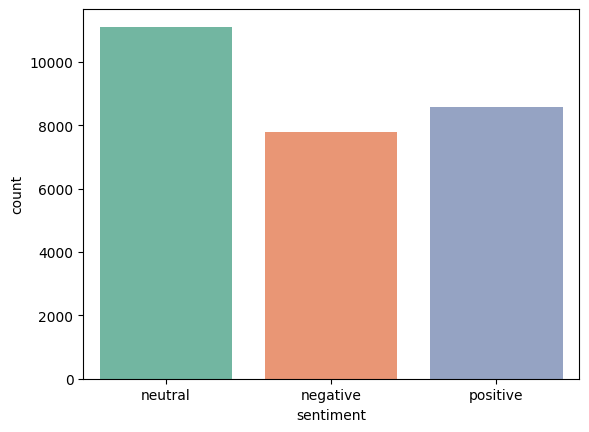

In [ ]:
import seaborn as sns
sns.countplot(data=tweets_data, x="sentiment", palette="Set2", hue="sentiment")

In [ ]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))

tweets_data[["text", "word_count"]].sample(10)

,text,word_count
14915,Ugh!! Why isn`t inFamous on xbox360!!!?? **** ...,12
25253,Bom dia! Good Morning! Guten Morgen! I am retu...,11
27050,says BAD TRIP! (angry) http://plurk.com/p/wxshi,6
13946,May the Forth be with you... ha yes... Today i...,23
19246,Choked on her retainers,4
940,or so a month. I put my 2 week`s notice in a ...,24
14161,"Yeah, I wanted to say this, that there`s a @ ...",23
9301,I hate my arrival in the employee parking lot!,9
1502,I don`t have enough close contacts on twitter ...,14
14308,i want magic mountain tix but i dont get ur s...,20


In [ ]:
# To check if the sentiment is dependent on word count
tweets_data.groupby("sentiment")["word_count"].mean()

,word_count
sentiment,
negative,14.244313
neutral,13.207610
positive,14.100210


In [ ]:
# just to make sure that the mean in not much influenced by outliers
tweets_data.groupby("sentiment")["word_count"].median()

,word_count
sentiment,
negative,13.0
neutral,12.0
positive,13.0


<Axes: xlabel='word_count', ylabel='Count'>

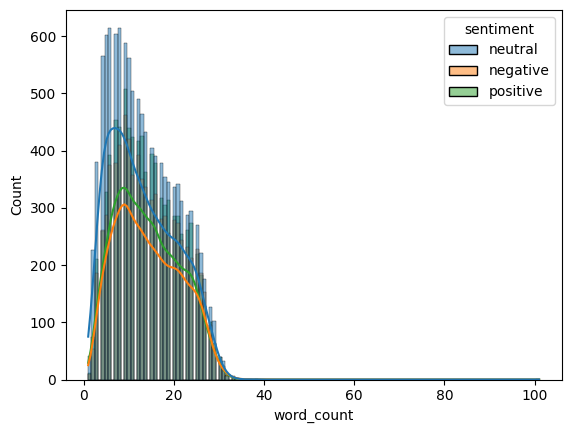

In [ ]:
sns.histplot(data=tweets_data, x="word_count", hue="sentiment", kde=True)

<Axes: ylabel='word_count'>

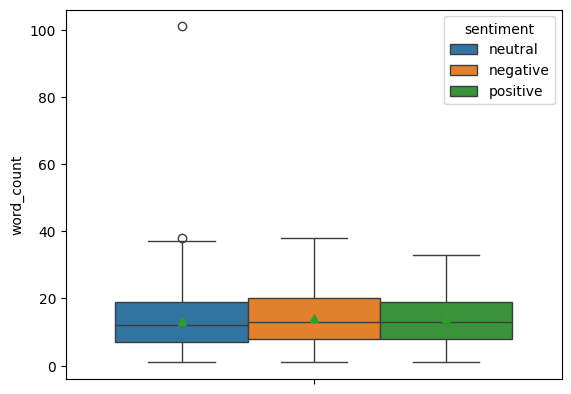

In [ ]:
sns.boxplot(data=tweets_data, y="word_count", hue="sentiment", showmeans = True)

# **Cleaning and Preprocessing**

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
preserve_words = {'not', 'no', 'never', "n't"}
stop_words = stop_words - preserve_words  # Remove preserved words from stopwords

print(len(stop_words))
print(stop_words)

196
{"we'll", 'on', 'when', 'by', 'between', 'themselves', 'its', 'wouldn', 'being', "should've", 'he', "don't", 'this', 'down', "i've", 'y', "needn't", 'shan', 'yourself', 'myself', 'be', 'her', 'or', 'further', 'a', 'once', "you'll", 'and', "she'd", 'from', 's', "we're", 'o', 'of', 'hasn', 're', "wasn't", 'couldn', 'was', 'has', 'same', "you've", 'out', "he'll", 'my', "it's", 'then', "she'll", 'ours', 'yours', 'are', 'than', 'aren', 'where', 'have', 'just', "that'll", 'at', 'm', 'ma', 'nor', 'should', "he's", "wouldn't", 'ourselves', 'until', 'too', "weren't", 'they', "it'd", 'had', "doesn't", 'ain', 'for', 'i', "you're", 'is', 'now', 'them', 'haven', "shan't", 'weren', 'did', 'mustn', "we'd", "they'll", 'having', 'it', 'most', 'both', "shouldn't", 'his', 'why', 'you', 'an', 'am', 'other', 'because', 'their', 'after', 'your', 'below', "he'd", 'how', 'isn', 'here', 'whom', 'own', 'won', "couldn't", 'theirs', 'there', 'through', 'wasn', 'if', 'herself', 'hadn', 'to', "won't", 'don', "i

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import string

def custom_standardization(input_data):
    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r'https?://\S+|www\.\S+', '')

    # Remove email addresses
    stripped_emails = tf.strings.regex_replace(stripped_urls, r'\S*@\S*\s?', '')

    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(stripped_emails, r'<.*?>', '')

    # Handle negations (e.g., "not good" to "not_good")
    negation_pattern = r"\b(?:not|no|never|n't)\s+(\w+)"
    handled_negations = tf.strings.regex_replace(stripped_html, negation_pattern, r'\1_\2')

    # Remove words with digits (e.g., alphanumeric strings)
    stripped_digits = tf.strings.regex_replace(handled_negations, r'\w*\d\w*', '')

    # Remove punctuation
    stripped_punctuation = tf.strings.regex_replace(stripped_digits, r'[{}]'.format(re.escape(string.punctuation)), '')

    # Remove stopwords
    stopwords_pattern = r'\b(?:{})\b'.format('|'.join(stop_words))
    stripped_stopwords = tf.strings.regex_replace(stripped_punctuation, stopwords_pattern, '')

    # Replace multiple whitespaces with a single space
    stripped_whitespace = tf.strings.regex_replace(stripped_stopwords, r'\s+', ' ')

    # Remove leading and trailing whitespaces
    cleaned_text = tf.strings.strip(stripped_whitespace)

    return cleaned_text

In [ ]:
tweets_data["text"][5]

'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth'

In [ ]:
# using numpy because out custom function returns text in a tensor format
custom_standardization(tweets_data["text"][5]).numpy()

b'shameless plugging best rangers forum earth'

In [ ]:
print(tweets_data["text"][20])
print(tweets_data["text"][527])
print(tweets_data["text"][11827])

 oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3
i am living in ignorance  :@
My Degree  [Tear] happy moment!  http://mypict.me/1ZpF


In [ ]:
print(custom_standardization(tweets_data["text"][20]).numpy())
print(custom_standardization(tweets_data["text"][527]).numpy())
print(custom_standardization(tweets_data["text"][11827]).numpy())

b'oh marly im sorry hope find soon'
b'living ignorance'
b'degree tear happy moment'


In [ ]:
tweets_data["cleaned_text"] = tweets_data["text"].apply(custom_standardization)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b'id responded going', shape=(), dty..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b'sooo sad miss san diego', shape=()..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b'boss bullying', shape=(), dtype=st..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b'interview leave alone', shape=(), ..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b'sons couldnt put releases already ...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b'wish could come see u denver husba...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b'ive wondered rake client made clea...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b'yay good enjoy break probably need...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b'worth', shape=(), dtype=string)"


In [ ]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode('utf-8')

In [ ]:
# Apply the fuction to DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons couldnt put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job ...
27477,I`ve wondered about rake to. The client has ...,negative,26,ive wondered rake client made clear net dont f...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,positive,8,worth


# **Word clouds**

In [ ]:
# Extract the text from poditive sentiemnt tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all poitive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a wordCloud object
positive_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(positive_text)

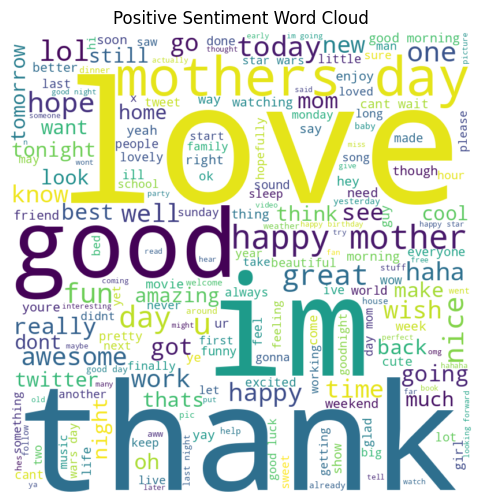

In [ ]:
# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.show()


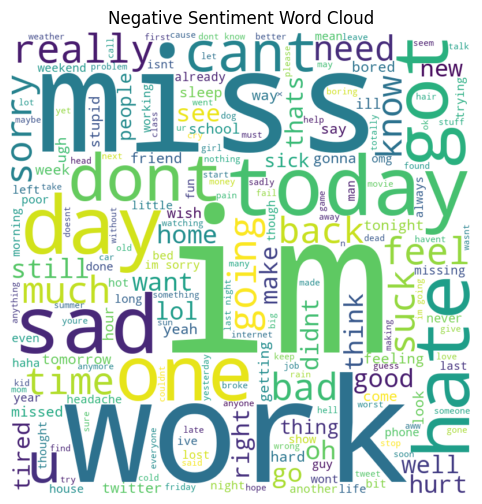

In [ ]:

# Extract the text from negative sentiment tweets
negative_tweets = tweets_data[tweets_data["sentiment"] == "negative"]["cleaned_text"]

# Concatenate all negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a wordCloud object
negative_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(negative_text)

# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")
plt.show()


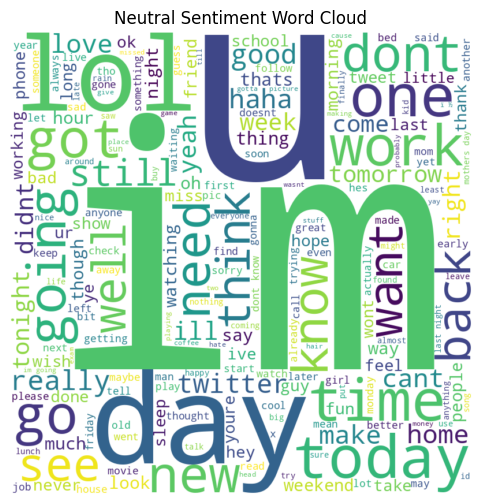

In [ ]:
# Extract the text from neutral sentiment tweets
neutral_tweets = tweets_data[tweets_data["sentiment"] == "neutral"]["cleaned_text"]

# Concatenate all neutral sentiment tweets into a single string
neutral_text = " ".join(neutral_tweets)

# Create a wordCloud object
neutral_wordcloud = WordCloud(width=800, height=800, background_color="white").generate(neutral_text)

# Plot the wordcloud
plt.figure(figsize=(10, 6), facecolor=None)
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Neutral Sentiment Word Cloud")
plt.show()


# **Feed forward neural network phase**

In [ ]:
# Converting sentiment into numeric representation
tweets_data["sentiment"] = tweets_data["sentiment"].map({"positive": 2, "neutral": 1, "negative": 0})

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",1,8,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,0,11,sooo sad miss san diego
2,my boss is bullying me...,0,5,boss bullying
3,what interview! leave me alone,0,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",0,15,sons couldnt put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,0,18,wish could come see u denver husband lost job ...
27477,I`ve wondered about rake to. The client has ...,0,26,ive wondered rake client made clear net dont f...
27478,Yay good for both of you. Enjoy the break - y...,2,24,yay good enjoy break probably need hectic week...
27479,But it was worth it ****.,2,8,worth


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size=0.2, stratify=tweets_data['sentiment'], random_state=123)
X_train, X_val = train_test_split(X_train, test_size=0.1, stratify=X_train['sentiment'], random_state=123)

X_train.shape, X_val.shape, X_test.shape

# X_train = To train
# X_val = To validate during training
# X_test = To evaluate model

((19785, 4), (2199, 4), (5496, 4))

In [ ]:
print(X_train['sentiment'].value_counts())
print(X_val['sentiment'].value_counts())
print(X_test['sentiment'].value_counts())

sentiment
1    8005
2    6178
0    5602
Name: count, dtype: int64
sentiment
1    889
2    687
0    623
Name: count, dtype: int64
sentiment
1    2223
2    1717
0    1556
Name: count, dtype: int64


In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train['text'].values, X_train['sentiment'].values)).shuffle(1024).batch(batch_size=128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val['text'].values, X_val['sentiment'].values)).batch(batch_size=128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test['text'].values, X_test['sentiment'].values)).batch(batch_size=128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)


(155, 18, 43)

In [ ]:
# Display a single batch from raw_test_ds
for text, sentiment in raw_test_ds.take(1):
    print("Text:", text.numpy()[:3])  # Display first 3 samples
    print("Sentiment:", sentiment.numpy()[:3])  # Display corresponding labels


Text: [b'Loving my boys' b' have a good show' b' nope  het is LOST&found he ;-)']
Sentiment: [2 2 0]


In [ ]:
# Check the structure of the dataset
print(raw_test_ds.element_spec)

(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


# **Count vectorization**

In [ ]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='count',
    ngrams=(1,2)
)

In [ ]:
train_text = raw_train_ds.map(lambda x, y:x)

count_vectorizer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return count_vectorizer(text), label

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

class_names = ["positive", "neutral", "negative"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized tweet: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b' Happy Anoop Day to you Monica', shape=(), dtype=string)
Sentiment:  negative
Vectorized tweet:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [ ]:
vocab_size = count_vectorizer.get_vocabulary()
len(vocab_size)

10000

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
dnn_model = Sequential([
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [ ]:
dnn_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = dnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4294 - loss: 1.0807 - val_accuracy: 0.5143 - val_loss: 1.0285
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5585 - loss: 0.9986 - val_accuracy: 0.5971 - val_loss: 0.9438
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6608 - loss: 0.8919 - val_accuracy: 0.6558 - val_loss: 0.8613
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7133 - loss: 0.7857 - val_accuracy: 0.6694 - val_loss: 0.8011
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7432 - loss: 0.6993 - val_accuracy: 0.6830 - val_loss: 0.7646
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7644 - loss: 0.6290 - val_accuracy: 0.6889 - val_loss: 0.7461
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7872 - loss: 0.5758 - val_accuracy: 0.6880 - val_loss: 0.7395
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8057 - loss: 0.5298 - val_accuracy: 0

In [ ]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6936 - loss: 0.7558
Loss:  0.773438036441803
Accuracy:  0.6852256059646606


In [ ]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history_df = pd.DataFrame(history_dict)

history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.464241,1.065668,0.514325,1.028523
1,0.576245,0.978161,0.597090,0.943845
2,0.667122,0.869103,0.655753,0.861295
3,0.716098,0.768016,0.669395,0.801137
4,0.744251,0.685916,0.683038,0.764554


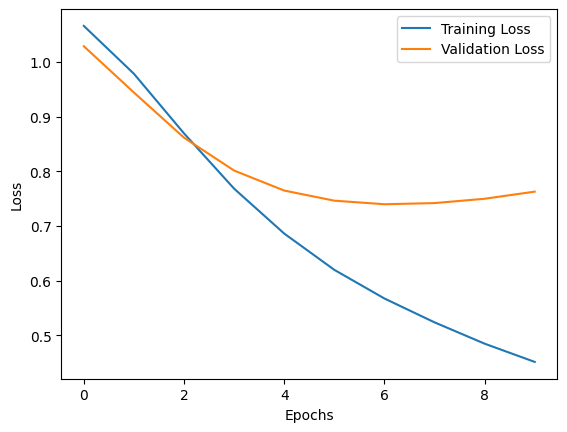

In [ ]:
# Plot against training and validation loss
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

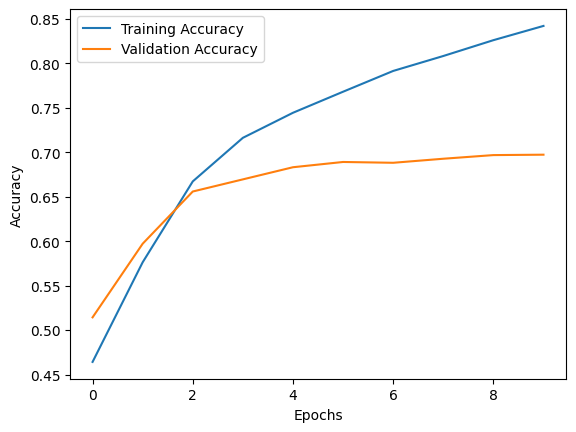

In [ ]:
# Plot against training and validation accuracy
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
export_model = Sequential([
    count_vectorizer,
    dnn_model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6936 - loss: 0.7558
Loss:  0.773438036441803
Accuracy:  0.6852256059646606


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions, axis=1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

report = classification_report(y_test, y_pred)

print( report)



172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1556
           1       0.63      0.70      0.66      2223
           2       0.76      0.71      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496



# **Using TF-IDF as vectorizer**

In [ ]:
vocab_size = 10000
tfidf_vectorizer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='tf_idf',
    ngrams=(1,2)
)

tfidf_vectorizer.adapt(train_text)

In [ ]:
def vectorize_text_tf_idf(text, label):
  text = tf.expand_dims(text, -1)

  return tfidf_vectorizer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text_tf_idf)
val_ds = raw_val_ds.map(vectorize_text_tf_idf)
test_ds = raw_test_ds.map(vectorize_text_tf_idf)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
dnn_model = Sequential([
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [ ]:
dnn_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = dnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.3298 - loss: 1.2343 - val_accuracy: 0.3743 - val_loss: 1.1299
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3613 - loss: 1.1505 - val_accuracy: 0.4120 - val_loss: 1.0848
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3980 - loss: 1.1064 - val_accuracy: 0.4475 - val_loss: 1.0630
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4208 - loss: 1.0790 - val_accuracy: 0.4670 - val_loss: 1.0464
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4457 - loss: 1.0632 - val_accuracy: 0.4889 - val_loss: 1.0310
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4728 - loss: 1.0373 - val_accuracy: 0.5111 - val_loss: 1.0158
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4883 - loss: 1.0196 - val_accuracy: 0.5293 - val_loss: 1.0008
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5180 - loss: 0.9960 - val_accuracy: 0

In [ ]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6809 - loss: 0.7617
Loss:  0.7810218334197998
Accuracy:  0.6715793013572693


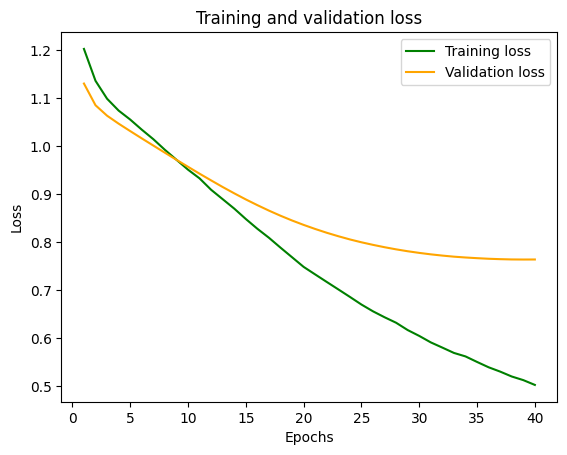

In [ ]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

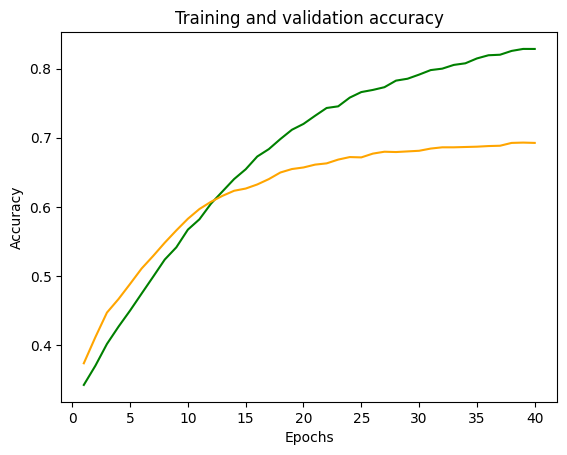

In [ ]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# **Text to Embeddings**

In [ ]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [ ]:
train_text=raw_train_ds.map(lambda x, y:x)

vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
test_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

We are using a callback list here

Early stopping — Interrupting training when the validation loss is no longer improving (and save the best model obtained during training). ReduceLROnPlateau-Dynamically adjusting the value of certain parameters during training such as the learning rate optimizer. Tensorboard-Logging training and validation metrics during training or visualizing representations learned by the model as they’re updated. (The Keras progress bar we always see in our terminal during training!)

Callbacks are passed to the during via the callback argument in the fit() method which takes a list of callbacks. Any number of callbacks can be passed to it.

The monitor argument in the EarlyStopping callback monitor’s the model’s validation accuracy and the patience argument interrupts training when the parameter passed to the monitor argument stops improving for more than the number (of epochs) passed to it (in this case 3).

Also, the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss has stopped improving. This has proven to be a very effective strategy to get out of local minima during training. The factor argument takes as input a float which is used to multipy the learning rate when triggered.Factor by which the learning rate will be reduced. new_lr = lr * factor.

In [ ]:
callback_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3
    ),
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=1
    )
]

**Neural network creation is started**

In [ ]:
embedding_dim = 64

model = Sequential([
    layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.1),
    layers.Dense(3)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callback_list
  )

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3965 - loss: 1.0917 - val_accuracy: 0.4043 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4042 - loss: 1.0877 - val_accuracy: 0.4043 - val_loss: 1.0914 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4050 - loss: 1.0882 - val_accuracy: 0.4043 - val_loss: 1.0852 - learning_rate: 1.0000e-04
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4051 - loss: 1.0851 - val_accuracy: 0.4043 - val_loss: 1.0848 - learning_rate: 1.0000e-04


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3930 - loss: 1.0881
Loss:  1.0848115682601929
Accuracy:  0.40447598695755005


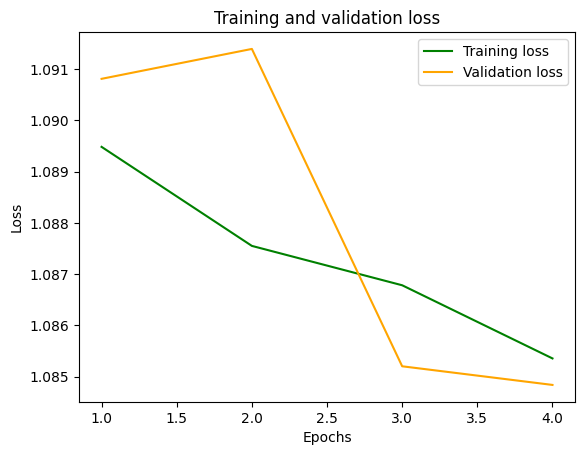

In [ ]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

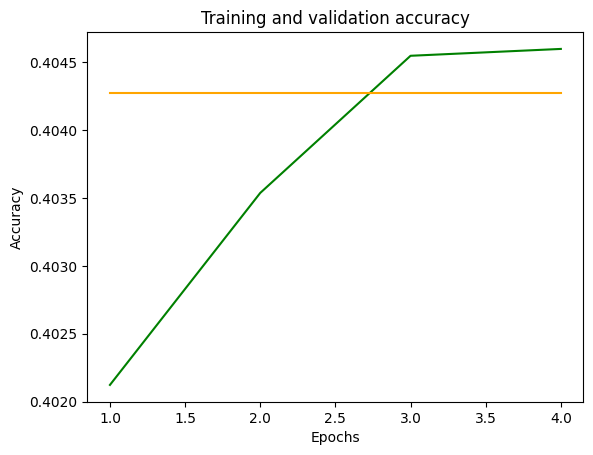

In [ ]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# **Recurrent Neural network**

In [ ]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
rnn_model.add(layers.SimpleRNN(128, return_sequences=True))
rnn_model.add(layers.GlobalMaxPool1D())
rnn_model.add(layers.Dense(3,activation='softmax'))

rnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = rnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.4614 - loss: 1.0273 - val_accuracy: 0.6776 - val_loss: 0.7422 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7210 - loss: 0.6747 - val_accuracy: 0.6830 - val_loss: 0.7368 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8073 - loss: 0.5031 - val_accuracy: 0.6721 - val_loss: 0.8346 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8729 - loss: 0.3701 - val_accuracy: 0.6717 - val_loss: 0.8693 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8935 - loss: 0.3217 - val_accuracy: 0.6767 - val_loss: 0.8567 - learning_rate: 1.0000e-05


In [ ]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6705 - loss: 0.8322
Loss:  0.8379529714584351
Accuracy:  0.6737627387046814


# **Training LSTM Network**

In [ ]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))
lstm_model.add(layers.SpatialDropout1D(0.25))
lstm_model.add(layers.LSTM(128, dropout= 0.6, return_sequences=True))
lstm_model.add(layers.GlobalMaxPooling1D())
lstm_model.add(layers.Dense(32,activation='tanh'))
lstm_model.add(layers.Dense(3,activation='softmax'))

lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4516 - loss: 1.0355 - val_accuracy: 0.6526 - val_loss: 0.7829 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6878 - loss: 0.7298 - val_accuracy: 0.6908 - val_loss: 0.7325 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7426 - loss: 0.6256 - val_accuracy: 0.6917 - val_loss: 0.7374 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7880 - loss: 0.5444 - val_accuracy: 0.7040 - val_loss: 0.7587 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7944 - loss: 0.5383 - val_accuracy: 0.7026 - val_loss: 0.7415 - learning_rate: 1.0000e-05
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7943 - loss: 0.5305 - val_accuracy: 0.7008 - val_loss: 0.7418 - learning_rate: 1.0000e-06
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.789

In [ ]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ",loss)
print("Accuracy: ",accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7042 - loss: 0.7299
Loss:  0.737653911113739
Accuracy:  0.7021470069885254


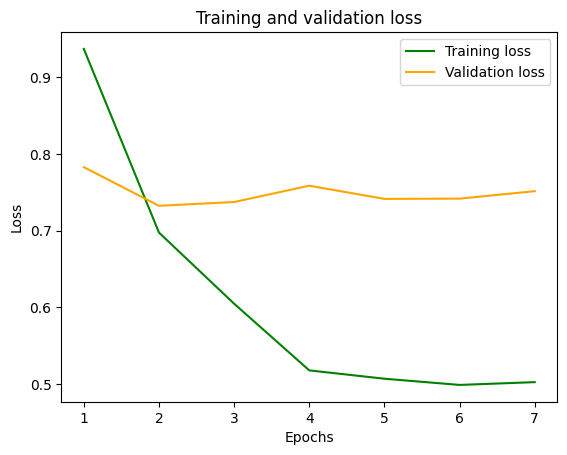

In [ ]:
#plot  against training and validation loss

history_dict = history.history

history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color= "green", label='Training loss')
plt.plot(epochs, val_loss, color="orange", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

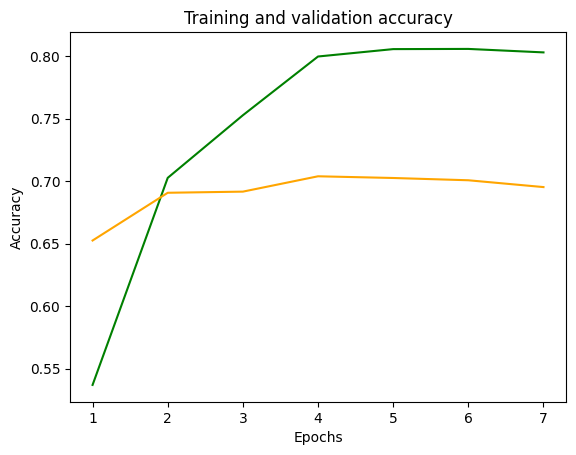

In [ ]:
plt.plot(epochs, acc, color= "green", label='Training acc')
plt.plot(epochs, val_acc, color="orange", label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


In [ ]:
export_model = Sequential([
    vectorize_layer,
    lstm_model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6939 - loss: 0.7377
Loss:  0.7442662119865417
Accuracy:  0.6943231225013733


In [ ]:
def predict_sentiment(text):
    text = tf.constant([text])

    prediction = export_model.predict(text)
    predicted_class = np.argmax(prediction, axis=1)[0]

    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = sentiment_labels.get(predicted_class, "Unknown")

    print(f"Input Text: {text.numpy()[0]}")
    print(f"Predicted Sentiment: {sentiment}")

In [ ]:
user_input = input("Enter a tweet or text to analyze sentiment: ")
predict_sentiment(user_input)

Enter a tweet or text to analyze sentiment: bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Input Text: b'bad'
Predicted Sentiment: Negative


In [ ]:
user_input = input("Enter a tweet or text to analyze sentiment: ")
predict_sentiment(user_input)

Enter a tweet or text to analyze sentiment: ok
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Text: b'ok'
Predicted Sentiment: Neutral


In [ ]:
import numpy as np
from tensorflow.keras import layers, Sequential, optimizers, losses, regularizers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Bidirectional, Attention
import tensorflow as tf

embedding_index = {}
glove_file = 'glove.6B.100d.txt'
embedding_dim = 100


print("Loading GloVe embeddings...")
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

# === Get Vocabulary and Prepare word_index ===
# Using existing vectorize_layer to get vocabulary
vocab = vectorize_layer.get_vocabulary()
vocab_size = len(vocab)  # Use the same vocab size as in TextVectorization

# Convert vocabulary list to a dictionary for consistent indexing
word_index = {word: index for index, word in enumerate(vocab)}

# === Create Embedding Matrix ===
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:  # Check to avoid indexing error
        # Skip OOV and padding tokens
        if word in ["<OOV>", ""]:
            continue
        # Get the embedding vector from GloVe
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Embedding matrix shape:", embedding_matrix.shape)
print("Embedding matrix successfully created.")


Loading GloVe embeddings...
Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (10000, 100)
Embedding matrix successfully created.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:

embedding_dim = 100
sequence_length = 300
learning_rate = 0.0001

# Updated Model Architecture
input_layer = Input(shape=(sequence_length,))
x = layers.Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     input_length=sequence_length,
                     trainable=False)(input_layer)
x = layers.SpatialDropout1D(0.3)(x)

# Increase Model Capacity: Stacking Bidirectional LSTM Layers
bi_lstm = Bidirectional(layers.LSTM(512, dropout=0.4, return_sequences=True))(x)
bi_lstm = Bidirectional(layers.LSTM(256, dropout=0.3, return_sequences=True))(bi_lstm)

# Attention Mechanism
class AttentionLayer(layers.Layer):
    def call(self, inputs):
        query, value = inputs, inputs
        score = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(distribution, value)
        return context

attention_output = AttentionLayer()(bi_lstm)
context_vector = layers.GlobalMaxPooling1D()(attention_output)

# Hidden Dense Layer with Reduced L2 Regularization
x = layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001))(context_vector)

# Output Layer
output_layer = layers.Dense(3, activation='softmax')(x)


enhanced_lstm_model = Model(inputs=input_layer, outputs=output_layer)
enhanced_lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),  # Reduced learning rate
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


enhanced_lstm_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 300, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 300, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 300, 1024)           │       2,510,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 300, 512)            │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 300, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,200,387 (23.65 MB)

 Trainable params: 5,200,387 (19.84 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Callbacks for Early Stopping and Model Checkpointing
callback_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2
    )
]

# Train the Model
history = enhanced_lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callback_list
)


Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 66s 397ms/step - accuracy: 0.4265 - loss: 1.2648 - val_accuracy: 0.5448 - val_loss: 1.1389 - learning_rate: 1.0000e-04
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 83s 402ms/step - accuracy: 0.5323 - loss: 1.1353 - val_accuracy: 0.5684 - val_loss: 1.0747 - learning_rate: 1.0000e-04
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 401ms/step - accuracy: 0.5586 - loss: 1.0853 - val_accuracy: 0.5784 - val_loss: 1.0469 - learning_rate: 1.0000e-04
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 401ms/step - accuracy: 0.5639 - loss: 1.0617 - val_accuracy: 0.5862 - val_loss: 1.0196 - learning_rate: 1.0000e-04
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 400ms/step - accuracy: 0.5713 - loss: 1.0417 - val_accuracy: 0.6035 - val_loss: 0.9959 - learning_rate: 1.0000e-04
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 400ms/step - accuracy: 0.5755 - loss: 1.0220 - val_accuracy: 0.5875 - val_loss: 0.9797 - learning_rate: 1.0000e-04
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 40

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6740 - loss: 0.7885
Test Loss:  0.7940576076507568
Test Accuracy:  0.6726710200309753


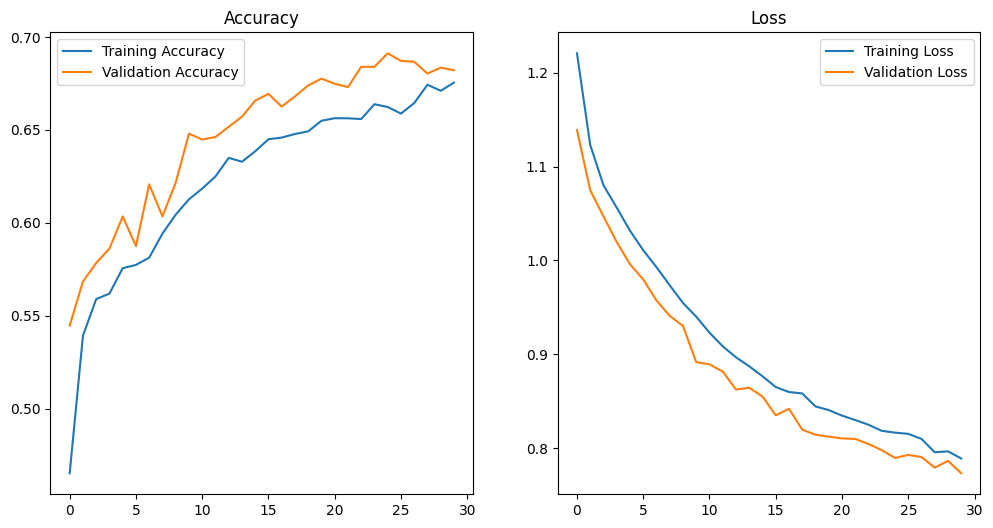

In [ ]:
# Evaluate on the test set
loss, accuracy = enhanced_lstm_model.evaluate(test_ds)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

# Visualize Training Performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()
